<a href="https://colab.research.google.com/github/andre-la-machado/cnr/blob/master/modelling_lstm_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM Modelling

On this Notebook, a LSTM Model will be tried for the Competitition Data.

## Libraries

In [1]:
%pip uninstall -q -y tensorflow
%pip install -q -U tensorflow-gpu>=2
%reset -f

In [2]:
!nvidia-smi

Mon Sep 21 23:26:30 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
sns.set_style('darkgrid')
from cnr_methods import get_selected_features, transform_data, revert_data, get_simplified_data
import random

from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
import tensorflow as tf
print(tf.test.is_built_with_cuda())  # Sanity check: GPU available to tf or not
print(tf.test.is_built_with_gpu_support())
print(tf.config.list_physical_devices('GPU'))
print(tf.__version__)  # Check if __version__>="2.0.0"
print(tf.keras.__version__)

True
True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
2.3.0
2.4.0


## Read Data

Here, the data used correspond to the results of the Feature Engineering and Selection Step. For simplicity, during Hyperparameter Optimization, only Wind Farm 3 Training Data is used.

In [36]:
full_data = pd.read_csv("Selected_Features_Data.csv")

#full_data = full_data.rename({'Unnamed: 0' : 'Time'},axis=1)
full_data = full_data.set_index('Time')

full_label = pd.read_csv('Y_train.csv')
X = full_data[full_data['Set']=='Train']

WF = 'WF3'
X = X[X['WF']==WF]
y = full_label[full_label['ID'].isin(X['ID'])]

In [6]:
X.head()

,ID,WF,U_100m,V_100m,U_10m,V_10m,T,CLCT,Set,Wind Speed 100m,Wind Direction 100m,Wind Speed 10m,Wind Direction 10m,T_lag_7_days,T_lag_14_days,T_lag_21_days,CLCT_lag_7_days,CLCT_lag_14_days,CLCT_lag_21_days,U_100m_lag_7_days,U_100m_lag_14_days,U_100m_lag_21_days,V_100m_lag_7_days,V_100m_lag_14_days,V_100m_lag_21_days,U_10m_lag_7_days,U_10m_lag_14_days,U_10m_lag_21_days,V_10m_lag_7_days,V_10m_lag_14_days,V_10m_lag_21_days,Month_Number,T_Last_Month_Mean,CLCT_Last_Month_Mean,U_100m_Last_Month_Mean,V_100m_Last_Month_Mean,U_10m_Last_Month_Mean,V_10m_Last_Month_Mean,TLast_Month_Variance,CLCTLast_Month_Variance,...,CLCT_Distance_Max,CLCT_Distance_Min,U_100m_Distance_Max,U_100m_Distance_Min,V_100m_Distance_Max,V_100m_Distance_Min,U_10m_Distance_Max,U_10m_Distance_Min,V_10m_Distance_Max,V_10m_Distance_Min,T_Rolling_7_Window_Mean,T_Rolling_14_Window_Mean,T_Rolling_7_Window_Variance,T_Rolling_14_Window_Variance,CLCT_Rolling_7_Window_Mean,CLCT_Rolling_14_Window_Mean,CLCT_Rolling_7_Window_Variance,CLCT_Rolling_14_Window_Variance,U_100m_Rolling_7_Window_Mean,U_100m_Rolling_14_Window_Mean,U_100m_Rolling_7_Window_Variance,U_100m_Rolling_14_Window_Variance,V_100m_Rolling_7_Window_Mean,V_100m_Rolling_14_Window_Mean,V_100m_Rolling_7_Window_Variance,V_100m_Rolling_14_Window_Variance,U_10m_Rolling_7_Window_Mean,U_10m_Rolling_14_Window_Mean,U_10m_Rolling_7_Window_Variance,U_10m_Rolling_14_Window_Variance,V_10m_Rolling_7_Window_Mean,V_10m_Rolling_14_Window_Mean,V_10m_Rolling_7_Window_Variance,V_10m_Rolling_14_Window_Variance,T_Expanded_Window_Max,CLCT_Expanded_Window_Max,U_100m_Expanded_Window_Max,V_100m_Expanded_Window_Max,U_10m_Expanded_Window_Max,V_10m_Expanded_Window_Max
Time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-05-01 01:00:00,12479,WF3,5.789500,3.820200,1.054669,1.317597,275.690,86.504507,Train,6.936299,0.583268,1.687717,0.895782,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1,-2,-223,-201,-193,-160,-223,-227,-193,-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,275.690,86.504507,5.7895,3.8202,1.054669,1.317597
2018-05-01 02:00:00,12480,WF3,6.003300,3.920600,0.876879,1.483483,275.770,98.976088,Train,7.170127,0.578533,1.723264,1.036951,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1,-2,-223,-201,-193,-160,-223,-227,-193,-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,275.770,98.976088,6.0033,3.9206,1.054669,1.483483
2018-05-01 03:00:00,12481,WF3,5.931829,0.907656,0.949640,1.419591,276.875,64.193607,Train,6.000870,0.151837,1.707938,0.981212,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1,-2,-223,-201,-193,-160,-223,-227,-193,-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,276.875,98.976088,6.0033,3.9206,1.054669,1.483483
2018-05-01 04:00:00,12482,WF3,5.205300,1.683800,1.027462,1.029786,275.650,57.482484,Train,5.470862,0.312855,1.454695,0.786528,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1,-2,-223,-201,-193,-160,-223,-227,-193,-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,276.875,98.976088,6.0033,3.9206,1.054669,1.483483
2018-05-01 05:00:00,12483,WF3,4.845900,0.702200,1.011645,0.785352,275.530,89.971463,Train,4.896512,0.143904,1.280704,0.660129,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1,-2,-223,-201,-193,-159,-223,-227,-193,-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,276.875,98.976088,6.0033,3.9206,1.054669,1.483483


## Scaling Data

For a better performance of the Network, here the data is scaled between [-1,1] using MinMaxScaler. For the Direction Data, presented in degrees, Sin and Cos are calculated, which naturally have values in this same scale.

In [37]:
def preprocessing_X(X):

  scaler = MinMaxScaler(feature_range=(-1,1))

  X_saved_columns = X[['ID','WF','Set','Month_Number']]
  X_saved_columns = X_saved_columns.reset_index().drop('Time',axis=1)
  X = X.drop(['ID','WF','Set','Month_Number'],axis=1)

  # Fill NaN's
  X = X.fillna(method="ffill", axis=1) # ZOH
  X = X.fillna(0)

  # Scaling Data
  directions = X[['Wind Direction 100m', 'Wind Direction 10m']]
  directions["Sin_Wind Direction 100m"] = np.sin(X['Wind Direction 100m']*(np.pi/180))
  directions["Cos_Wind Direction 100m"] = np.cos(X['Wind Direction 100m']*(np.pi/180))
  directions["Sin_Wind Direction 10m"] = np.sin(X['Wind Direction 10m']*(np.pi/180))
  directions["Cos_Wind Direction 10m"] = np.cos(X['Wind Direction 10m']*(np.pi/180))
  directions = directions.drop(['Wind Direction 100m', 'Wind Direction 10m'],axis=1)
  directions = directions.reset_index().drop('Time',axis=1)

  X = X.drop(['Wind Direction 100m', 'Wind Direction 10m'],axis=1)
  X_columns = X.columns

  X = scaler.fit_transform(X)
  X = pd.DataFrame(X,columns=X_columns)
  X = pd.concat([X,directions],axis=1)
  X = pd.concat([X,X_saved_columns],axis=1)

  return X

In [38]:
def preprocessing_y(y):

  scaler = MinMaxScaler(feature_range=(-1,1))

  y = y.fillna(method="ffill", axis=1) # ZOH
  y = y.fillna(0)
  y = y.drop('ID',axis=1)
  y = scaler.fit_transform(y)
  y = pd.DataFrame(y)

  return y,scaler

In [9]:
y.shape

(6239, 2)

## Subsets Creation

Here, the Data is converted to a group of subsets where each subset has n_steps of past data.

In [10]:
n_steps = 30

In [11]:
# split a multivariate sequence into samples
def split_sequences(X, y = None, n_steps = 1):
	sample_X, sample_y = list(), list()
	for i in range(len(X)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(X):
			break
		# gather input and output parts of the pattern
		seq_x = X[i:end_ix, :]
		sample_X.append(seq_x)
		if y is not None:
			seq_y = y[end_ix-1,-1]
			sample_y.append(seq_y)
	return np.array(sample_X), np.array(sample_y)

In [12]:
def shift_save(df,n_steps):
  empty = pd.DataFrame(np.zeros((n_steps-1,df.shape[1])),columns=df.columns)
  df = pd.concat([empty,df])
  return df

In [42]:
sample_X,sample_y = split_sequences(X.values,y.values,n_steps)

In [14]:
n_features = sample_X.shape[2] - 2

## Model

Here, a function to create the Model usin Keras is defined.

In [15]:
def LSTM_Model(input_shape, batch_size=1):
  # Numerical branch

  input_layer = tf.keras.Input(shape = input_shape,batch_size = batch_size)

  hidden_1 = tf.keras.layers.LSTM(units=128,return_sequences=True,stateful=True)(input_layer)
  hidden_1 = tf.keras.layers.Dropout(0.2)(hidden_1)

  hidden_2 = tf.keras.layers.LSTM(units=87,return_sequences=True,stateful=True)(hidden_1)
  hidden_2 = tf.keras.layers.Dropout(0.2)(hidden_2)

  hidden_3 = tf.keras.layers.LSTM(units=57,stateful=True)(hidden_2)
  hidden_3 = tf.keras.layers.Dropout(0.2)(hidden_3)

  # Output
  #outputs = tf.keras.layers.PReLU()(hidden_2)
  #outputs = tf.keras.layers.Dropout(rate=0.2)(hidden_2)
  outputs = tf.keras.layers.Dense(units=1)(hidden_3)

  model = tf.keras.Model(inputs=input_layer, outputs=outputs)

  return model

In [16]:
input_shape = (n_steps,n_features)

In [17]:
model = LSTM_Model(input_shape)

In [18]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(1, 30, 94)]             0         
_________________________________________________________________
lstm (LSTM)                  (1, 30, 128)              114176    
_________________________________________________________________
dropout (Dropout)            (1, 30, 128)              0         
_________________________________________________________________
lstm_1 (LSTM)                (1, 30, 87)               75168     
_________________________________________________________________
dropout_1 (Dropout)          (1, 30, 87)               0         
_________________________________________________________________
lstm_2 (LSTM)                (1, 57)                   33060     
_________________________________________________________________
dropout_2 (Dropout)          (1, 57)                  

## Validation

In [19]:
random.seed(317)
tf.random.set_seed(317)

patience = 3
epochs = 10
k_fold_splits = 5
total_it = 50
monitor = "root_mean_squared_error"
batch_size = 1

In [20]:
# Define Time Split Cross Validation
tscv = TimeSeriesSplit(n_splits=k_fold_splits)

# Separating Data from Hold Out Set

X_cv, _, y_cv, _ = train_test_split(X, y, test_size=0.125, shuffle=False)

train_scores = np.empty(0)
val_scores = np.empty(0)
test_scores = np.empty(0)
for train_index, test_index in tscv.split(X_cv):

    #train_index = train_index[-n_rows:]
    #test_index = test_index[-n_rows:]

    # Get the Data of the Split
    X_train, X_test = X_cv.iloc[train_index], X_cv.iloc[test_index]
    y_train, y_test = y_cv.iloc[train_index], y_cv.iloc[test_index]

    # Separating Training Set of Split on Train and Validation Subsets
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.143, shuffle=False)

    # Preprocessing Data
    X_train = preprocessing_X(X_train)
    X_val = preprocessing_X(X_val)
    X_test = preprocessing_X(X_test)

    X_train = X_train.drop(['ID','WF','Set','Month_Number'],axis=1)
    X_val = X_val.drop(['ID','WF','Set','Month_Number'],axis=1)
    X_test = X_test.drop(['ID','WF','Set','Month_Number'],axis=1)

    y_train,_ = preprocessing_y(y_train)
    y_val,_ = preprocessing_y(y_val)
    y_test,_ = preprocessing_y(y_test)

    # Reshape Data
    X_train, y_train = split_sequences(X_train.values,y_train.values,n_steps)
    X_val, y_val = split_sequences(X_val.values,y_val.values,n_steps)
    X_test, y_test = split_sequences(X_test.values,y_test.values,n_steps)

    # Create Model
    model = LSTM_Model(input_shape,batch_size=batch_size)

    # Callbacks
    callbacks_list = [tf.keras.callbacks.EarlyStopping(monitor=monitor, patience=patience, verbose=0, min_delta=1e-8)]

    # Train the Model
    model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
    history = model.fit(x = X_train, y = y_train, batch_size = batch_size, epochs = epochs, validation_data = (X_val, y_val), callbacks=callbacks_list,shuffle=False)

    # Train and Validation Score
    train_score = np.array(history.history['root_mean_squared_error']).mean()
    val_score = np.array(history.history['val_root_mean_squared_error']).mean()

    # Test Score
    preds = model.predict(X_test,batch_size = batch_size,callbacks=callbacks_list)
    preds = tf.cast(preds, tf.float32)
    y_test = tf.cast(y_test, tf.float32)

    m = tf.keras.metrics.RootMeanSquaredError()
    m.update_state(y_test,preds)
    test_score = m.result().numpy()

    train_scores = np.append(train_scores,train_score)
    val_scores = np.append(val_scores,val_score)
    test_scores = np.append(test_scores,test_score)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Epoch 1/10
754/754 [==============================] - 6s 8ms/step - loss: 0.1410 - root_mean_squared_error: 0.3755 - val_loss: 0.2070 - val_root_mean_squared_error: 0.4550
Epoch 2/10
754/754 [==============================] - 5s 7ms/step - loss: 0.1412 - root_mean_squared_error: 0.3757 - val_loss: 0.2148 - val_root_mean_squared_error: 0.4635
Epoch 3/10
754/754 [==============================] - 6s 7ms/step - loss: 0.1462 - root_mean_squared_error: 0.3823 - val_loss: 0.1871 - val_root_mean_squared_error: 0.4325
Epoch 4/10
754/754 [==============================] - 6s 8ms/step - loss: 0.1348 - root_mean_squared_error: 0.3672 - val_loss: 0.1772 - val_root_mean_squared_error: 0.4209
Epoch 5/10
754/754 [==============================] - 6s 8ms/step - loss: 0.1062 - root_mean_squared_error: 0.3260 - val_loss: 0.1166 - val_root_mean_squared_error: 0.3414
Epoch 6/10
754/754 [==============================] - 6s 7ms/step - loss: 0.1102 - root_mean_squared_error: 0.3320 - val_loss: 0.1473 - val_

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Epoch 1/10
1533/1533 [==============================] - 13s 8ms/step - loss: 0.1142 - root_mean_squared_error: 0.3380 - val_loss: 0.1843 - val_root_mean_squared_error: 0.4293
Epoch 2/10
1533/1533 [==============================] - 12s 8ms/step - loss: 0.1024 - root_mean_squared_error: 0.3201 - val_loss: 0.2341 - val_root_mean_squared_error: 0.4839
Epoch 3/10
1533/1533 [==============================] - 12s 8ms/step - loss: 0.1076 - root_mean_squared_error: 0.3281 - val_loss: 0.1753 - val_root_mean_squared_error: 0.4186
Epoch 4/10
1533/1533 [==============================] - 11s 7ms/step - loss: 0.1041 - root_mean_squared_error: 0.3226 - val_loss: 0.1681 - val_root_mean_squared_error: 0.4100
Epoch 5/10
1533/1533 [==============================] - 12s 8ms/step - loss: 0.0932 - root_mean_squared_error: 0.3052 - val_loss: 0.1387 - val_root_mean_squared_error: 0.3724
Epoch 6/10
1533/1533 [==============================] - 11s 7ms/step - loss: 0.0763 - root_mean_squared_error: 0.2763 - val_l

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Epoch 1/10
2312/2312 [==============================] - 19s 8ms/step - loss: 0.1116 - root_mean_squared_error: 0.3341 - val_loss: 0.1462 - val_root_mean_squared_error: 0.3824
Epoch 2/10
2312/2312 [==============================] - 18s 8ms/step - loss: 0.0979 - root_mean_squared_error: 0.3128 - val_loss: 0.1150 - val_root_mean_squared_error: 0.3390
Epoch 3/10
2312/2312 [==============================] - 18s 8ms/step - loss: 0.0816 - root_mean_squared_error: 0.2856 - val_loss: 0.1312 - val_root_mean_squared_error: 0.3623
Epoch 4/10
2312/2312 [==============================] - 18s 8ms/step - loss: 0.0737 - root_mean_squared_error: 0.2714 - val_loss: 0.1311 - val_root_mean_squared_error: 0.3621
Epoch 5/10
2312/2312 [==============================] - 18s 8ms/step - loss: 0.0624 - root_mean_squared_error: 0.2497 - val_loss: 0.1101 - val_root_mean_squared_error: 0.3319
Epoch 6/10
2312/2312 [==============================] - 18s 8ms/step - loss: 0.0566 - root_mean_squared_error: 0.2379 - val_l

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Epoch 1/10
3091/3091 [==============================] - 25s 8ms/step - loss: 0.1017 - root_mean_squared_error: 0.3189 - val_loss: 0.2064 - val_root_mean_squared_error: 0.4543
Epoch 2/10
3091/3091 [==============================] - 24s 8ms/step - loss: 0.1038 - root_mean_squared_error: 0.3222 - val_loss: 0.1729 - val_root_mean_squared_error: 0.4159
Epoch 3/10
3091/3091 [==============================] - 24s 8ms/step - loss: 0.1013 - root_mean_squared_error: 0.3183 - val_loss: 0.1657 - val_root_mean_squared_error: 0.4070
Epoch 4/10
3091/3091 [==============================] - 24s 8ms/step - loss: 0.0916 - root_mean_squared_error: 0.3027 - val_loss: 0.1621 - val_root_mean_squared_error: 0.4026
Epoch 5/10
3091/3091 [==============================] - 24s 8ms/step - loss: 0.0830 - root_mean_squared_error: 0.2881 - val_loss: 0.1377 - val_root_mean_squared_error: 0.3710
Epoch 6/10
3091/3091 [==============================] - 24s 8ms/step - loss: 0.0689 - root_mean_squared_error: 0.2625 - val_l

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Epoch 1/10
3870/3870 [==============================] - 30s 8ms/step - loss: 0.0828 - root_mean_squared_error: 0.2878 - val_loss: 0.2132 - val_root_mean_squared_error: 0.4618
Epoch 2/10
3870/3870 [==============================] - 29s 7ms/step - loss: 0.0735 - root_mean_squared_error: 0.2710 - val_loss: 0.2606 - val_root_mean_squared_error: 0.5105
Epoch 3/10
3870/3870 [==============================] - 30s 8ms/step - loss: 0.0612 - root_mean_squared_error: 0.2473 - val_loss: 0.1424 - val_root_mean_squared_error: 0.3774
Epoch 4/10
3870/3870 [==============================] - 29s 7ms/step - loss: 0.0518 - root_mean_squared_error: 0.2276 - val_loss: 0.0984 - val_root_mean_squared_error: 0.3137
Epoch 5/10
3870/3870 [==============================] - 29s 8ms/step - loss: 0.0409 - root_mean_squared_error: 0.2021 - val_loss: 0.1297 - val_root_mean_squared_error: 0.3602
Epoch 6/10
3870/3870 [==============================] - 29s 7ms/step - loss: 0.0371 - root_mean_squared_error: 0.1926 - val_l

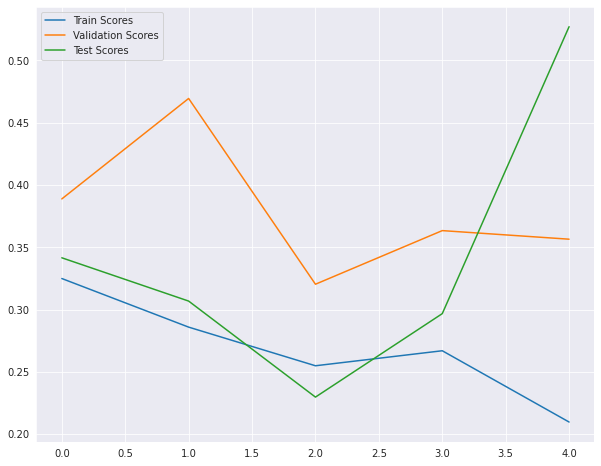

In [21]:
plt.figure(figsize=(10,8))
plt.plot(range(len(train_scores)),train_scores,label='Train Scores')
plt.plot(range(len(val_scores)),val_scores,label='Validation Scores')
plt.plot(range(len(test_scores)),test_scores,label='Test Scores')
plt.legend()

### Hold Out Score

Here, the same model is trained on all the data used on the Validation and tested on a Holdout Set never seen before.

In [22]:
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.125, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.143, shuffle=False)

In [23]:
X_train = preprocessing_X(X_train)
X_val = preprocessing_X(X_val)
X_holdout = preprocessing_X(X_holdout)

X_train = X_train.drop(['ID','WF','Set','Month_Number'],axis=1)
X_val = X_val.drop(['ID','WF','Set','Month_Number'],axis=1)
X_holdout = X_holdout.drop(['ID','WF','Set','Month_Number'],axis=1)

y_train,scaler = preprocessing_y(y_train)
y_val,_ = preprocessing_y(y_val)
y_holdout,_ = preprocessing_y(y_holdout)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

In [24]:
X_train, y_train = split_sequences(X_train.values,y_train.values,n_steps)
X_val, y_val = split_sequences(X_val.values,y_val.values,n_steps)
X_holdout, y_holdout = split_sequences(X_holdout.values,y_holdout.values,n_steps)

In [25]:
model = LSTM_Model(input_shape)

In [26]:
callbacks_list = [tf.keras.callbacks.EarlyStopping(monitor=monitor, patience=patience, verbose=0, min_delta=1e-8)]
model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
model.fit(x = X_train, y = y_train, batch_size = batch_size, epochs = epochs, validation_data = (X_val, y_val), callbacks=callbacks_list)

Epoch 1/10
4649/4649 [==============================] - 35s 8ms/step - loss: 0.0605 - root_mean_squared_error: 0.2459 - val_loss: 0.1079 - val_root_mean_squared_error: 0.3285
Epoch 2/10
4649/4649 [==============================] - 35s 8ms/step - loss: 0.0346 - root_mean_squared_error: 0.1860 - val_loss: 0.1390 - val_root_mean_squared_error: 0.3728
Epoch 3/10
4649/4649 [==============================] - 36s 8ms/step - loss: 0.0295 - root_mean_squared_error: 0.1717 - val_loss: 0.1435 - val_root_mean_squared_error: 0.3789
Epoch 4/10
4649/4649 [==============================] - 35s 8ms/step - loss: 0.0264 - root_mean_squared_error: 0.1625 - val_loss: 0.1452 - val_root_mean_squared_error: 0.3811
Epoch 5/10
4649/4649 [==============================] - 35s 8ms/step - loss: 0.0231 - root_mean_squared_error: 0.1520 - val_loss: 0.1704 - val_root_mean_squared_error: 0.4128
Epoch 6/10
4649/4649 [==============================] - 36s 8ms/step - loss: 0.0235 - root_mean_squared_error: 0.1534 - val_l

In [27]:
preds = model.predict(X_holdout,batch_size = batch_size,callbacks=callbacks_list)

Here, Predicitions and True Labels of the Holdout Set are scaled back to measure the CAPE Error, and be compared on a Chart.

In [28]:
preds = scaler.inverse_transform(preds)
y_holdout = scaler.inverse_transform(pd.DataFrame(y_holdout))

In [29]:
def metric_cnr(preds,labels):
    cape_cnr = 100*np.sum(np.abs(preds-labels))/np.sum(labels)
    return 'CAPE', cape_cnr

In [30]:
metric_cnr(preds,y_holdout)

('CAPE', 58.4790366924186)

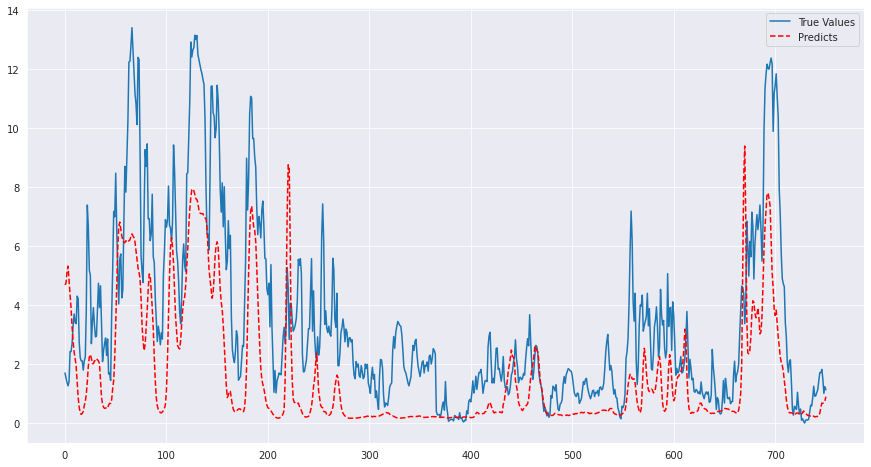

In [31]:
plt.figure(figsize=(15,8))
preds_len = np.arange(len(y_holdout))
plt.plot(preds_len,y_holdout,label='True Values')
plt.plot(preds_len,preds,'r--',label='Predicts')
plt.legend()

## Submission Generation

First, a function with all the preprocessing made to prepare data for network is defined.

Here's a Function with all the Process of Submit Gen for One Wind Farm. This Model is the Standard:

In [ ]:
def WF_submit_gen(full_data,full_label,WF,input_shape,batch_size):
  # Get Data of Wind Farm
  X_WF = full_data[full_data['WF']==WF]

  # Scale X Data
  X_WF = preprocessing_X(X_WF)

  full_X_train = X_WF[X_WF['Set']=='Train']
  full_X_test = X_WF[X_WF['Set']=='Test']
  full_y_train = full_label[full_label['ID'].isin(full_X_train['ID'])]

  # Scale y_train
  full_y_train,scaler_y = preprocessing_y(full_y_train)

  # Subsets Generation
  full_X_train = full_X_train.drop(['ID','WF','Set'],axis=1)
  full_X_train, full_y_train = split_sequences(full_X_train.values,full_y_train.values,n_steps)

  full_X_test = full_X_test.reset_index().drop('index',axis=1)
  full_X_test_split = full_X_test.drop(['ID','WF','Set'],axis=1)
  full_X_test_split = shift_save(full_X_test_split,n_steps)
  full_X_test_split, _ = split_sequences(full_X_test_split.values,None,n_steps)

  # Months Loop
  WF_preds = np.empty(0)
  predicted_X_test = np.empty((0,60,95))
  for month in full_X_test['Month_Number'].unique():

    print("Farm {} - Month {}".format(WF,month))

    # Special Condition for Month 10
    if month == 9:
      X_test = full_X_test[full_X_test['Month_Number']==month]
      X_test_10 = full_X_test[full_X_test['Month_Number']==10]
      X_test = pd.concat([X_test,X_test_10])
    else:
      X_test = full_X_test[full_X_test['Month_Number']==month]

    if month == 10:
      continue
    
    # Separate Month Data on Numpy Matrix
    ids = X_test.index
    X_test = full_X_test_split[[ids]]

    # Append Data Already Predicted
    X_train = np.append(full_X_train,predicted_X_test,axis=0)
    y_train = np.append(full_y_train,WF_preds,axis=0)

    # Split Train Data on Train and Validation Set
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)

    # Model Creation and Training
    model = LSTM_Model(input_shape,batch_size=batch_size)
    callbacks_list = [tf.keras.callbacks.EarlyStopping(monitor=monitor, patience=patience, verbose=0, min_delta=1e-8)]
    model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
    model.fit(x = X_train, y = y_train, batch_size = batch_size, epochs = epochs, validation_data = (X_val, y_val), callbacks=callbacks_list,shuffle=False)

    # Prediction Generation
    pred = model.predict(X_test,batch_size = batch_size,callbacks=callbacks_list)
    pred = pred.reshape(pred.shape[0])

    # Save Predictions on Final Array
    predicted_X_test = np.append(predicted_X_test,X_test,axis=0)
    WF_preds = np.append(WF_preds,pred)

  WF_preds = scaler_y.inverse_transform(pd.DataFrame(WF_preds))
  WF_preds = pd.DataFrame(WF_preds,columns=['Production'])

  return WF_preds

In [ ]:
def WF_submit_gen_2(full_data,full_label,WF,input_shape,batch_size):
  # Get Data of Wind Farm
  X_WF = full_data[full_data['WF']==WF]

  full_X_train = X_WF[X_WF['Set']=='Train']
  full_X_test = X_WF[X_WF['Set']=='Test']
  full_y_train = full_label[full_label['ID'].isin(full_X_train['ID'])]

  # Months Loop
  WF_preds = pd.DataFrame(columns=['Production'])
  predicted_X_test = pd.DataFrame(columns=full_X_train.columns)
  predicted_X_test.index.names = ['Time']
  for month in full_X_test['Month_Number'].unique():

    print("Farm {} - Month {}".format(WF,month))

    # Special Condition for Month 10
    if month == 9:
      X_test = full_X_test[full_X_test['Month_Number']==month]
      X_test_10 = full_X_test[full_X_test['Month_Number']==10]
      X_test_pure = pd.concat([X_test,X_test_10])
    else:
      X_test_pure = full_X_test[full_X_test['Month_Number']==month]

    if month == 10:
      continue

    # Append Data Already Predicted
    X_train = pd.concat([full_X_train,predicted_X_test])
    y_train = pd.concat([full_y_train,WF_preds])

    # Split Train Data on Train and Validation Set
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)

    # Preprocessing Data
    X_train = preprocessing_X(X_train)
    X_val = preprocessing_X(X_val)
    X_test = preprocessing_X(X_test_pure)

    # Shift-Save on X_test
    X_test = shift_save(X_test,n_steps)

    X_train = X_train.drop(['ID','WF','Set','Month_Number'],axis=1)
    X_val = X_val.drop(['ID','WF','Set','Month_Number'],axis=1)
    X_test = X_test.drop(['ID','WF','Set','Month_Number'],axis=1)

    y_train,scaler_y = preprocessing_y(y_train)
    y_val,_ = preprocessing_y(y_val)

    # Subset Creation 

    X_train, y_train = split_sequences(X_train.values,y_train.values,n_steps)
    X_val, y_val = split_sequences(X_val.values,y_val.values,n_steps)
    X_test, _ = split_sequences(X_test.values,None,n_steps)

    # Model Creation and Training
    model = LSTM_Model(input_shape,batch_size=batch_size)
    callbacks_list = [tf.keras.callbacks.EarlyStopping(monitor=monitor, patience=patience, verbose=0, min_delta=1e-8)]
    model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
    model.fit(x = X_train, y = y_train, batch_size = batch_size, epochs = epochs, validation_data = (X_val, y_val), callbacks=callbacks_list,shuffle=False)

    # Prediction Generation
    pred = model.predict(X_test,batch_size = batch_size,callbacks=callbacks_list)
    pred = pred.reshape(pred.shape[0])
    pred = pd.DataFrame(pred,columns=['Production'])
    #pred = shift_save(pred,n_steps)

    # Save Predictions on Final Array
    predicted_X_test = pd.concat([predicted_X_test,X_test_pure])
    WF_preds = pd.concat([WF_preds,pred])

  WF_preds = scaler_y.inverse_transform(pd.DataFrame(WF_preds))
  WF_preds = pd.DataFrame(WF_preds,columns=['Production'])

  return WF_preds

Direct Submit Generation:

In [ ]:
def WF_submit_gen_3(full_data,full_label,WF,input_shape,batch_size):
  # Get Data of Wind Farm
  X_WF = full_data[full_data['WF']==WF]

  # Scale X Data
  X_WF = preprocessing_X(X_WF)

  full_X_train = X_WF[X_WF['Set']=='Train']
  full_X_test = X_WF[X_WF['Set']=='Test']
  full_y_train = full_label[full_label['ID'].isin(full_X_train['ID'])]

  # Scale y_train
  full_y_train,scaler_y = preprocessing_y(full_y_train)

  # Subsets Generation
  full_X_train = full_X_train.drop(['ID','WF','Set'],axis=1)
  full_X_train, full_y_train = split_sequences(full_X_train.values,full_y_train.values,n_steps)

  full_X_test_split = full_X_test.drop(['ID','WF','Set'],axis=1)
  full_X_test_split = shift_save(full_X_test_split,n_steps)
  full_X_test_split, _ = split_sequences(full_X_test_split.values,None,n_steps)

  # Split Train Data on Train and Validation Set
  X_train, X_val, y_train, y_val = train_test_split(full_X_train, full_y_train, test_size=0.3, shuffle=False)

  # Model Creation and Training
  model = LSTM_Model(input_shape,batch_size=batch_size)
  callbacks_list = [tf.keras.callbacks.EarlyStopping(monitor=monitor, patience=patience, verbose=0, min_delta=1e-8)]
  model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
  model.fit(x = X_train, y = y_train, batch_size = batch_size, epochs = epochs, validation_data = (X_val, y_val), callbacks=callbacks_list,shuffle=False)

  # Prediction Generation
  pred = model.predict(full_X_test_split,batch_size = batch_size,callbacks=callbacks_list)
  pred = pred.reshape(pred.shape[0])

  WF_preds = scaler_y.inverse_transform(pd.DataFrame(pred))
  WF_preds = pd.DataFrame(WF_preds,columns=['Production'])

  return WF_preds

In [ ]:
final_preds = pd.DataFrame()
for WF in full_data['WF'].unique():
  WF_preds = WF_submit_gen_2(full_data,full_label,WF,input_shape,batch_size)
  final_preds = final_preds.append(WF_preds)

Farm WF1 - Month 1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Epoch 1/10
4962/4962 [==============================] - 42s 9ms/step - loss: 0.0989 - root_mean_squared_error: 0.3145 - val_loss: 0.6140 - val_root_mean_squared_error: 0.7836
Epoch 2/10
4962/4962 [==============================] - 43s 9ms/step - loss: 0.1011 - root_mean_squared_error: 0.3179 - val_loss: 0.2934 - val_root_mean_squared_error: 0.5417
Epoch 3/10
4962/4962 [==============================] - 42s 9ms/step - loss: 0.0929 - root_mean_squared_error: 0.3048 - val_loss: 0.2812 - val_root_mean_squared_error: 0.5303
Epoch 4/10
4962/4962 [==============================] - 42s 9ms/step - loss: 0.0951 - root_mean_squared_error: 0.3084 - val_loss: 0.3061 - val_root_mean_squared_error: 0.5533
Epoch 5/10
4962/4962 [==============================] - 41s 8ms/step - loss: 0.0798 - root_mean_squared_error: 0.2824 - val_loss: 0.2770 - val_root_mean_squared_error: 0.5263
Epoch 6/10
4962/4962 [==============================] - 41s 8ms/step - loss: 0.0624 - root_mean_squared_error: 0.2498 - val_l

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Epoch 1/10
5268/5268 [==============================] - 44s 8ms/step - loss: 0.1086 - root_mean_squared_error: 0.3295 - val_loss: 0.2979 - val_root_mean_squared_error: 0.5458
Epoch 2/10
5268/5268 [==============================] - 43s 8ms/step - loss: 0.0999 - root_mean_squared_error: 0.3161 - val_loss: 0.2982 - val_root_mean_squared_error: 0.5460
Epoch 3/10
5268/5268 [==============================] - 43s 8ms/step - loss: 0.0867 - root_mean_squared_error: 0.2945 - val_loss: 0.2222 - val_root_mean_squared_error: 0.4714
Epoch 4/10
5268/5268 [==============================] - 43s 8ms/step - loss: 0.0684 - root_mean_squared_error: 0.2616 - val_loss: 0.1620 - val_root_mean_squared_error: 0.4025
Epoch 5/10
5268/5268 [==============================] - 44s 8ms/step - loss: 0.0494 - root_mean_squared_error: 0.2223 - val_loss: 0.1421 - val_root_mean_squared_error: 0.3770
Epoch 6/10
5268/5268 [==============================] - 44s 8ms/step - loss: 0.0403 - root_mean_squared_error: 0.2007 - val_l

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Epoch 1/10
5806/5806 [==============================] - 48s 8ms/step - loss: 0.1195 - root_mean_squared_error: 0.3457 - val_loss: 0.1080 - val_root_mean_squared_error: 0.3286
Epoch 2/10
5806/5806 [==============================] - 48s 8ms/step - loss: 0.1178 - root_mean_squared_error: 0.3432 - val_loss: 0.2554 - val_root_mean_squared_error: 0.5054
Epoch 3/10
5806/5806 [==============================] - 49s 9ms/step - loss: 0.1170 - root_mean_squared_error: 0.3421 - val_loss: 0.1001 - val_root_mean_squared_error: 0.3165
Epoch 4/10
5806/5806 [==============================] - 48s 8ms/step - loss: 0.0901 - root_mean_squared_error: 0.3002 - val_loss: 0.1644 - val_root_mean_squared_error: 0.4054
Epoch 5/10
5806/5806 [==============================] - 48s 8ms/step - loss: 0.0622 - root_mean_squared_error: 0.2494 - val_loss: 0.1260 - val_root_mean_squared_error: 0.3549
Epoch 6/10
5806/5806 [==============================] - 49s 8ms/step - loss: 0.0499 - root_mean_squared_error: 0.2234 - val_l

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Epoch 1/10
6401/6401 [==============================] - 54s 9ms/step - loss: 0.1017 - root_mean_squared_error: 0.3190 - val_loss: 0.5480 - val_root_mean_squared_error: 0.7403
Epoch 2/10
6401/6401 [==============================] - 53s 8ms/step - loss: 0.1038 - root_mean_squared_error: 0.3222 - val_loss: 0.5078 - val_root_mean_squared_error: 0.7126
Epoch 3/10
6401/6401 [==============================] - 53s 8ms/step - loss: 0.1019 - root_mean_squared_error: 0.3191 - val_loss: 0.4887 - val_root_mean_squared_error: 0.6991
Epoch 4/10
6401/6401 [==============================] - 53s 8ms/step - loss: 0.0994 - root_mean_squared_error: 0.3152 - val_loss: 0.5437 - val_root_mean_squared_error: 0.7374
Epoch 5/10
6401/6401 [==============================] - 54s 8ms/step - loss: 0.1014 - root_mean_squared_error: 0.3185 - val_loss: 0.5362 - val_root_mean_squared_error: 0.7323
Epoch 6/10
6401/6401 [==============================] - 53s 8ms/step - loss: 0.0953 - root_mean_squared_error: 0.3088 - val_l

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Epoch 1/10
6977/6977 [==============================] - 59s 8ms/step - loss: 0.0883 - root_mean_squared_error: 0.2971 - val_loss: 0.4618 - val_root_mean_squared_error: 0.6796
Epoch 2/10
6977/6977 [==============================] - 58s 8ms/step - loss: 0.0923 - root_mean_squared_error: 0.3038 - val_loss: 0.4493 - val_root_mean_squared_error: 0.6703
Epoch 3/10
6977/6977 [==============================] - 58s 8ms/step - loss: 0.0953 - root_mean_squared_error: 0.3086 - val_loss: 0.4387 - val_root_mean_squared_error: 0.6624
Epoch 4/10
6977/6977 [==============================] - 58s 8ms/step - loss: 0.0943 - root_mean_squared_error: 0.3071 - val_loss: 0.4933 - val_root_mean_squared_error: 0.7024
Farm WF1 - Month 6


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Epoch 1/10
7572/7572 [==============================] - 63s 8ms/step - loss: 0.0856 - root_mean_squared_error: 0.2926 - val_loss: 0.3181 - val_root_mean_squared_error: 0.5640
Epoch 2/10
7572/7572 [==============================] - 63s 8ms/step - loss: 0.0878 - root_mean_squared_error: 0.2963 - val_loss: 0.1260 - val_root_mean_squared_error: 0.3550
Epoch 3/10
7572/7572 [==============================] - 62s 8ms/step - loss: 0.0879 - root_mean_squared_error: 0.2965 - val_loss: 0.1224 - val_root_mean_squared_error: 0.3499
Epoch 4/10
7572/7572 [==============================] - 64s 8ms/step - loss: 0.0886 - root_mean_squared_error: 0.2976 - val_loss: 0.1085 - val_root_mean_squared_error: 0.3294
Farm WF1 - Month 7


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Epoch 1/10
8148/8148 [==============================] - 68s 8ms/step - loss: 0.0797 - root_mean_squared_error: 0.2823 - val_loss: 0.0519 - val_root_mean_squared_error: 0.2278
Epoch 2/10
8148/8148 [==============================] - 67s 8ms/step - loss: 0.0796 - root_mean_squared_error: 0.2821 - val_loss: 0.0612 - val_root_mean_squared_error: 0.2474
Epoch 3/10
8148/8148 [==============================] - 67s 8ms/step - loss: 0.0773 - root_mean_squared_error: 0.2780 - val_loss: 0.0509 - val_root_mean_squared_error: 0.2256
Epoch 4/10
8148/8148 [==============================] - 67s 8ms/step - loss: 0.0782 - root_mean_squared_error: 0.2797 - val_loss: 0.0494 - val_root_mean_squared_error: 0.2222
Epoch 5/10
8148/8148 [==============================] - 67s 8ms/step - loss: 0.0814 - root_mean_squared_error: 0.2852 - val_loss: 0.0546 - val_root_mean_squared_error: 0.2338
Epoch 6/10
8148/8148 [==============================] - 67s 8ms/step - loss: 0.0761 - root_mean_squared_error: 0.2758 - val_l

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Epoch 1/10
8743/8743 [==============================] - 74s 8ms/step - loss: 0.0739 - root_mean_squared_error: 0.2719 - val_loss: 0.1729 - val_root_mean_squared_error: 0.4159
Epoch 2/10
8743/8743 [==============================] - 73s 8ms/step - loss: 0.0725 - root_mean_squared_error: 0.2693 - val_loss: 0.1461 - val_root_mean_squared_error: 0.3822
Epoch 3/10
8743/8743 [==============================] - 73s 8ms/step - loss: 0.0756 - root_mean_squared_error: 0.2750 - val_loss: 0.1557 - val_root_mean_squared_error: 0.3946
Epoch 4/10
8743/8743 [==============================] - 73s 8ms/step - loss: 0.0797 - root_mean_squared_error: 0.2823 - val_loss: 0.1747 - val_root_mean_squared_error: 0.4180
Epoch 5/10
8743/8743 [==============================] - 73s 8ms/step - loss: 0.0750 - root_mean_squared_error: 0.2739 - val_loss: 0.1743 - val_root_mean_squared_error: 0.4175
Farm WF1 - Month 9


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Epoch 1/10
9339/9339 [==============================] - 78s 8ms/step - loss: 0.0662 - root_mean_squared_error: 0.2573 - val_loss: 0.2411 - val_root_mean_squared_error: 0.4910
Epoch 2/10
9339/9339 [==============================] - 77s 8ms/step - loss: 0.0702 - root_mean_squared_error: 0.2650 - val_loss: 0.1684 - val_root_mean_squared_error: 0.4104
Epoch 3/10
9339/9339 [==============================] - 78s 8ms/step - loss: 0.0728 - root_mean_squared_error: 0.2698 - val_loss: 0.1856 - val_root_mean_squared_error: 0.4308
Epoch 4/10
9339/9339 [==============================] - 78s 8ms/step - loss: 0.0738 - root_mean_squared_error: 0.2716 - val_loss: 0.1829 - val_root_mean_squared_error: 0.4277
Farm WF2 - Month 1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Epoch 1/10
4962/4962 [==============================] - 42s 8ms/step - loss: 0.0927 - root_mean_squared_error: 0.3044 - val_loss: 0.3086 - val_root_mean_squared_error: 0.5555
Epoch 2/10
4962/4962 [==============================] - 41s 8ms/step - loss: 0.0947 - root_mean_squared_error: 0.3077 - val_loss: 0.3416 - val_root_mean_squared_error: 0.5844
Epoch 3/10
4962/4962 [==============================] - 41s 8ms/step - loss: 0.0919 - root_mean_squared_error: 0.3032 - val_loss: 0.2708 - val_root_mean_squared_error: 0.5203
Epoch 4/10
4962/4962 [==============================] - 42s 9ms/step - loss: 0.0726 - root_mean_squared_error: 0.2695 - val_loss: 0.2085 - val_root_mean_squared_error: 0.4566
Epoch 5/10
4962/4962 [==============================] - 41s 8ms/step - loss: 0.0515 - root_mean_squared_error: 0.2269 - val_loss: 0.1988 - val_root_mean_squared_error: 0.4458
Epoch 6/10
4962/4962 [==============================] - 41s 8ms/step - loss: 0.0425 - root_mean_squared_error: 0.2062 - val_l

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Epoch 1/10
5268/5268 [==============================] - 45s 9ms/step - loss: 0.1067 - root_mean_squared_error: 0.3267 - val_loss: 0.3222 - val_root_mean_squared_error: 0.5676
Epoch 2/10
5268/5268 [==============================] - 44s 8ms/step - loss: 0.1004 - root_mean_squared_error: 0.3169 - val_loss: 0.2978 - val_root_mean_squared_error: 0.5457
Epoch 3/10
5268/5268 [==============================] - 44s 8ms/step - loss: 0.1063 - root_mean_squared_error: 0.3260 - val_loss: 0.2450 - val_root_mean_squared_error: 0.4950
Epoch 4/10
5268/5268 [==============================] - 44s 8ms/step - loss: 0.0919 - root_mean_squared_error: 0.3031 - val_loss: 0.2642 - val_root_mean_squared_error: 0.5140
Epoch 5/10
5268/5268 [==============================] - 45s 9ms/step - loss: 0.0715 - root_mean_squared_error: 0.2673 - val_loss: 0.1971 - val_root_mean_squared_error: 0.4439
Epoch 6/10
5268/5268 [==============================] - 44s 8ms/step - loss: 0.0531 - root_mean_squared_error: 0.2304 - val_l

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Epoch 1/10
5806/5806 [==============================] - 49s 8ms/step - loss: 0.1119 - root_mean_squared_error: 0.3345 - val_loss: 0.3925 - val_root_mean_squared_error: 0.6265
Epoch 2/10
5806/5806 [==============================] - 49s 8ms/step - loss: 0.1183 - root_mean_squared_error: 0.3439 - val_loss: 0.2498 - val_root_mean_squared_error: 0.4998
Epoch 3/10
5806/5806 [==============================] - 48s 8ms/step - loss: 0.1045 - root_mean_squared_error: 0.3233 - val_loss: 0.1091 - val_root_mean_squared_error: 0.3303
Epoch 4/10
5806/5806 [==============================] - 49s 8ms/step - loss: 0.0888 - root_mean_squared_error: 0.2980 - val_loss: 0.3150 - val_root_mean_squared_error: 0.5613
Epoch 5/10
5806/5806 [==============================] - 50s 9ms/step - loss: 0.0640 - root_mean_squared_error: 0.2530 - val_loss: 0.1134 - val_root_mean_squared_error: 0.3368
Epoch 6/10
5806/5806 [==============================] - 49s 8ms/step - loss: 0.0510 - root_mean_squared_error: 0.2259 - val_l

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Epoch 1/10
6401/6401 [==============================] - 54s 8ms/step - loss: 0.1007 - root_mean_squared_error: 0.3173 - val_loss: 0.3583 - val_root_mean_squared_error: 0.5986
Epoch 2/10
6401/6401 [==============================] - 53s 8ms/step - loss: 0.1028 - root_mean_squared_error: 0.3206 - val_loss: 0.4154 - val_root_mean_squared_error: 0.6445
Epoch 3/10
6401/6401 [==============================] - 53s 8ms/step - loss: 0.1034 - root_mean_squared_error: 0.3215 - val_loss: 0.4495 - val_root_mean_squared_error: 0.6704
Epoch 4/10
6401/6401 [==============================] - 54s 8ms/step - loss: 0.1013 - root_mean_squared_error: 0.3183 - val_loss: 0.3578 - val_root_mean_squared_error: 0.5982
Farm WF2 - Month 5


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Epoch 1/10
6977/6977 [==============================] - 58s 8ms/step - loss: 0.0957 - root_mean_squared_error: 0.3094 - val_loss: 0.3485 - val_root_mean_squared_error: 0.5903
Epoch 2/10
6977/6977 [==============================] - 57s 8ms/step - loss: 0.0957 - root_mean_squared_error: 0.3093 - val_loss: 0.3323 - val_root_mean_squared_error: 0.5765
Epoch 3/10
6977/6977 [==============================] - 57s 8ms/step - loss: 0.0956 - root_mean_squared_error: 0.3092 - val_loss: 0.3668 - val_root_mean_squared_error: 0.6057
Epoch 4/10
6977/6977 [==============================] - 57s 8ms/step - loss: 0.0973 - root_mean_squared_error: 0.3119 - val_loss: 0.3638 - val_root_mean_squared_error: 0.6032
Epoch 5/10
6977/6977 [==============================] - 58s 8ms/step - loss: 0.0955 - root_mean_squared_error: 0.3090 - val_loss: 0.3338 - val_root_mean_squared_error: 0.5777
Epoch 6/10
6977/6977 [==============================] - 57s 8ms/step - loss: 0.0973 - root_mean_squared_error: 0.3119 - val_l

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Epoch 1/10
7572/7572 [==============================] - 63s 8ms/step - loss: 0.0837 - root_mean_squared_error: 0.2893 - val_loss: 0.0768 - val_root_mean_squared_error: 0.2772
Epoch 2/10
7572/7572 [==============================] - 62s 8ms/step - loss: 0.0880 - root_mean_squared_error: 0.2967 - val_loss: 0.0784 - val_root_mean_squared_error: 0.2800
Epoch 3/10
7572/7572 [==============================] - 61s 8ms/step - loss: 0.0906 - root_mean_squared_error: 0.3009 - val_loss: 0.0812 - val_root_mean_squared_error: 0.2850
Epoch 4/10
7572/7572 [==============================] - 62s 8ms/step - loss: 0.0882 - root_mean_squared_error: 0.2969 - val_loss: 0.0814 - val_root_mean_squared_error: 0.2853
Farm WF2 - Month 7


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Epoch 1/10
8148/8148 [==============================] - 68s 8ms/step - loss: 0.0819 - root_mean_squared_error: 0.2861 - val_loss: 0.7679 - val_root_mean_squared_error: 0.8763
Epoch 2/10
8148/8148 [==============================] - 66s 8ms/step - loss: 0.0801 - root_mean_squared_error: 0.2830 - val_loss: 0.7977 - val_root_mean_squared_error: 0.8931
Epoch 3/10
8148/8148 [==============================] - 66s 8ms/step - loss: 0.0838 - root_mean_squared_error: 0.2895 - val_loss: 0.7915 - val_root_mean_squared_error: 0.8897
Epoch 4/10
8148/8148 [==============================] - 66s 8ms/step - loss: 0.0837 - root_mean_squared_error: 0.2892 - val_loss: 0.7860 - val_root_mean_squared_error: 0.8866
Epoch 5/10
8148/8148 [==============================] - 66s 8ms/step - loss: 0.0845 - root_mean_squared_error: 0.2907 - val_loss: 0.7629 - val_root_mean_squared_error: 0.8735
Farm WF2 - Month 8


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Epoch 1/10
8743/8743 [==============================] - 73s 8ms/step - loss: 0.0721 - root_mean_squared_error: 0.2685 - val_loss: 0.5662 - val_root_mean_squared_error: 0.7525
Epoch 2/10
8743/8743 [==============================] - 71s 8ms/step - loss: 0.0759 - root_mean_squared_error: 0.2754 - val_loss: 0.6453 - val_root_mean_squared_error: 0.8033
Epoch 3/10
8743/8743 [==============================] - 71s 8ms/step - loss: 0.0766 - root_mean_squared_error: 0.2767 - val_loss: 0.6485 - val_root_mean_squared_error: 0.8053
Epoch 4/10
8743/8743 [==============================] - 70s 8ms/step - loss: 0.0787 - root_mean_squared_error: 0.2806 - val_loss: 0.6549 - val_root_mean_squared_error: 0.8092
Farm WF2 - Month 9


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Epoch 1/10
9339/9339 [==============================] - 77s 8ms/step - loss: 0.0657 - root_mean_squared_error: 0.2564 - val_loss: 0.3867 - val_root_mean_squared_error: 0.6219
Epoch 2/10
9339/9339 [==============================] - 76s 8ms/step - loss: 0.0728 - root_mean_squared_error: 0.2697 - val_loss: 0.3643 - val_root_mean_squared_error: 0.6035
Epoch 3/10
9339/9339 [==============================] - 76s 8ms/step - loss: 0.0738 - root_mean_squared_error: 0.2716 - val_loss: 0.3847 - val_root_mean_squared_error: 0.6203
Epoch 4/10
9339/9339 [==============================] - 75s 8ms/step - loss: 0.0738 - root_mean_squared_error: 0.2716 - val_loss: 0.3650 - val_root_mean_squared_error: 0.6041
Farm WF3 - Month 1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Epoch 1/10
4962/4962 [==============================] - 42s 8ms/step - loss: 0.1037 - root_mean_squared_error: 0.3220 - val_loss: 0.9218 - val_root_mean_squared_error: 0.9601
Epoch 2/10
4962/4962 [==============================] - 40s 8ms/step - loss: 0.0951 - root_mean_squared_error: 0.3084 - val_loss: 0.2940 - val_root_mean_squared_error: 0.5422
Epoch 3/10
4962/4962 [==============================] - 40s 8ms/step - loss: 0.0915 - root_mean_squared_error: 0.3024 - val_loss: 0.3725 - val_root_mean_squared_error: 0.6103
Epoch 4/10
4962/4962 [==============================] - 40s 8ms/step - loss: 0.0939 - root_mean_squared_error: 0.3065 - val_loss: 0.2899 - val_root_mean_squared_error: 0.5385
Epoch 5/10
4962/4962 [==============================] - 40s 8ms/step - loss: 0.0941 - root_mean_squared_error: 0.3067 - val_loss: 0.2729 - val_root_mean_squared_error: 0.5224
Epoch 6/10
4962/4962 [==============================] - 40s 8ms/step - loss: 0.0931 - root_mean_squared_error: 0.3051 - val_l

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Epoch 1/10
5268/5268 [==============================] - 43s 8ms/step - loss: 0.1128 - root_mean_squared_error: 0.3359 - val_loss: 0.3437 - val_root_mean_squared_error: 0.5863
Epoch 2/10
5268/5268 [==============================] - 42s 8ms/step - loss: 0.1065 - root_mean_squared_error: 0.3264 - val_loss: 0.3052 - val_root_mean_squared_error: 0.5525
Epoch 3/10
5268/5268 [==============================] - 43s 8ms/step - loss: 0.1021 - root_mean_squared_error: 0.3196 - val_loss: 0.2932 - val_root_mean_squared_error: 0.5415
Epoch 4/10
5268/5268 [==============================] - 42s 8ms/step - loss: 0.1033 - root_mean_squared_error: 0.3214 - val_loss: 0.2662 - val_root_mean_squared_error: 0.5159
Epoch 5/10
5268/5268 [==============================] - 42s 8ms/step - loss: 0.0918 - root_mean_squared_error: 0.3029 - val_loss: 0.2385 - val_root_mean_squared_error: 0.4884
Epoch 6/10
5268/5268 [==============================] - 42s 8ms/step - loss: 0.0638 - root_mean_squared_error: 0.2526 - val_l

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Epoch 1/10
5806/5806 [==============================] - 47s 8ms/step - loss: 0.1162 - root_mean_squared_error: 0.3409 - val_loss: 0.1119 - val_root_mean_squared_error: 0.3345
Epoch 2/10
5806/5806 [==============================] - 46s 8ms/step - loss: 0.1095 - root_mean_squared_error: 0.3310 - val_loss: 0.1229 - val_root_mean_squared_error: 0.3506
Epoch 3/10
5806/5806 [==============================] - 46s 8ms/step - loss: 0.0849 - root_mean_squared_error: 0.2914 - val_loss: 0.1753 - val_root_mean_squared_error: 0.4187
Epoch 4/10
5806/5806 [==============================] - 46s 8ms/step - loss: 0.0598 - root_mean_squared_error: 0.2446 - val_loss: 0.1882 - val_root_mean_squared_error: 0.4339
Epoch 5/10
5806/5806 [==============================] - 45s 8ms/step - loss: 0.0457 - root_mean_squared_error: 0.2139 - val_loss: 0.1317 - val_root_mean_squared_error: 0.3629
Epoch 6/10
5806/5806 [==============================] - 46s 8ms/step - loss: 0.0398 - root_mean_squared_error: 0.1996 - val_l

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Epoch 1/10
6401/6401 [==============================] - 51s 8ms/step - loss: 0.1003 - root_mean_squared_error: 0.3168 - val_loss: 0.2687 - val_root_mean_squared_error: 0.5184
Epoch 2/10
6401/6401 [==============================] - 51s 8ms/step - loss: 0.1015 - root_mean_squared_error: 0.3186 - val_loss: 0.1834 - val_root_mean_squared_error: 0.4283
Epoch 3/10
6401/6401 [==============================] - 51s 8ms/step - loss: 0.1003 - root_mean_squared_error: 0.3167 - val_loss: 0.2113 - val_root_mean_squared_error: 0.4597
Epoch 4/10
6401/6401 [==============================] - 51s 8ms/step - loss: 0.0939 - root_mean_squared_error: 0.3065 - val_loss: 0.2394 - val_root_mean_squared_error: 0.4892
Epoch 5/10
6401/6401 [==============================] - 50s 8ms/step - loss: 0.0620 - root_mean_squared_error: 0.2491 - val_loss: 0.2521 - val_root_mean_squared_error: 0.5020
Epoch 6/10
6401/6401 [==============================] - 50s 8ms/step - loss: 0.0467 - root_mean_squared_error: 0.2161 - val_l

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Epoch 1/10
6977/6977 [==============================] - 55s 8ms/step - loss: 0.0965 - root_mean_squared_error: 0.3107 - val_loss: 0.5096 - val_root_mean_squared_error: 0.7138
Epoch 2/10
6977/6977 [==============================] - 55s 8ms/step - loss: 0.0991 - root_mean_squared_error: 0.3148 - val_loss: 0.2715 - val_root_mean_squared_error: 0.5211
Epoch 3/10
6977/6977 [==============================] - 54s 8ms/step - loss: 0.0988 - root_mean_squared_error: 0.3143 - val_loss: 0.2517 - val_root_mean_squared_error: 0.5017
Epoch 4/10
6977/6977 [==============================] - 55s 8ms/step - loss: 0.0959 - root_mean_squared_error: 0.3097 - val_loss: 0.2684 - val_root_mean_squared_error: 0.5181
Epoch 5/10
6977/6977 [==============================] - 56s 8ms/step - loss: 0.0972 - root_mean_squared_error: 0.3118 - val_loss: 0.2660 - val_root_mean_squared_error: 0.5157
Epoch 6/10
6977/6977 [==============================] - 55s 8ms/step - loss: 0.0863 - root_mean_squared_error: 0.2937 - val_l

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Epoch 1/10
7572/7572 [==============================] - 60s 8ms/step - loss: 0.0888 - root_mean_squared_error: 0.2979 - val_loss: 2.0940 - val_root_mean_squared_error: 1.4471
Epoch 2/10
7572/7572 [==============================] - 59s 8ms/step - loss: 0.0892 - root_mean_squared_error: 0.2987 - val_loss: 2.0821 - val_root_mean_squared_error: 1.4430
Epoch 3/10
7572/7572 [==============================] - 59s 8ms/step - loss: 0.0870 - root_mean_squared_error: 0.2949 - val_loss: 1.9836 - val_root_mean_squared_error: 1.4084
Epoch 4/10
7572/7572 [==============================] - 59s 8ms/step - loss: 0.0885 - root_mean_squared_error: 0.2974 - val_loss: 1.8961 - val_root_mean_squared_error: 1.3770
Epoch 5/10
7572/7572 [==============================] - 60s 8ms/step - loss: 0.0902 - root_mean_squared_error: 0.3004 - val_loss: 1.8090 - val_root_mean_squared_error: 1.3450
Epoch 6/10
7572/7572 [==============================] - 60s 8ms/step - loss: 0.0948 - root_mean_squared_error: 0.3080 - val_l

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Epoch 1/10
8148/8148 [==============================] - 65s 8ms/step - loss: 0.0787 - root_mean_squared_error: 0.2805 - val_loss: 1.9463 - val_root_mean_squared_error: 1.3951
Epoch 2/10
8148/8148 [==============================] - 63s 8ms/step - loss: 0.0799 - root_mean_squared_error: 0.2827 - val_loss: 2.0062 - val_root_mean_squared_error: 1.4164
Epoch 3/10
8148/8148 [==============================] - 63s 8ms/step - loss: 0.0819 - root_mean_squared_error: 0.2862 - val_loss: 2.1673 - val_root_mean_squared_error: 1.4722
Epoch 4/10
8148/8148 [==============================] - 64s 8ms/step - loss: 0.0822 - root_mean_squared_error: 0.2868 - val_loss: 2.0869 - val_root_mean_squared_error: 1.4446
Farm WF3 - Month 8


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Epoch 1/10
8743/8743 [==============================] - 69s 8ms/step - loss: 0.0417 - root_mean_squared_error: 0.2041 - val_loss: 2.3843 - val_root_mean_squared_error: 1.5441
Epoch 2/10
8743/8743 [==============================] - 68s 8ms/step - loss: 0.0429 - root_mean_squared_error: 0.2070 - val_loss: 2.3839 - val_root_mean_squared_error: 1.5440
Epoch 3/10
8743/8743 [==============================] - 68s 8ms/step - loss: 0.0419 - root_mean_squared_error: 0.2048 - val_loss: 2.3341 - val_root_mean_squared_error: 1.5278
Epoch 4/10
8743/8743 [==============================] - 68s 8ms/step - loss: 0.0436 - root_mean_squared_error: 0.2088 - val_loss: 2.3310 - val_root_mean_squared_error: 1.5268
Farm WF3 - Month 9


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Epoch 1/10
9339/9339 [==============================] - 73s 8ms/step - loss: 0.0376 - root_mean_squared_error: 0.1939 - val_loss: 0.6834 - val_root_mean_squared_error: 0.8267
Epoch 2/10
9339/9339 [==============================] - 72s 8ms/step - loss: 0.0389 - root_mean_squared_error: 0.1973 - val_loss: 0.6770 - val_root_mean_squared_error: 0.8228
Epoch 3/10
9339/9339 [==============================] - 72s 8ms/step - loss: 0.0389 - root_mean_squared_error: 0.1972 - val_loss: 0.6757 - val_root_mean_squared_error: 0.8220
Epoch 4/10
9339/9339 [==============================] - 72s 8ms/step - loss: 0.0401 - root_mean_squared_error: 0.2004 - val_loss: 0.6824 - val_root_mean_squared_error: 0.8261
Farm WF4 - Month 1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Epoch 1/10
4962/4962 [==============================] - 40s 8ms/step - loss: 0.1015 - root_mean_squared_error: 0.3186 - val_loss: 0.4360 - val_root_mean_squared_error: 0.6603
Epoch 2/10
4962/4962 [==============================] - 39s 8ms/step - loss: 0.0987 - root_mean_squared_error: 0.3142 - val_loss: 0.2685 - val_root_mean_squared_error: 0.5181
Epoch 3/10
4962/4962 [==============================] - 38s 8ms/step - loss: 0.0811 - root_mean_squared_error: 0.2848 - val_loss: 0.2516 - val_root_mean_squared_error: 0.5016
Epoch 4/10
4962/4962 [==============================] - 38s 8ms/step - loss: 0.0601 - root_mean_squared_error: 0.2452 - val_loss: 0.3017 - val_root_mean_squared_error: 0.5493
Epoch 5/10
4962/4962 [==============================] - 38s 8ms/step - loss: 0.0495 - root_mean_squared_error: 0.2224 - val_loss: 0.1873 - val_root_mean_squared_error: 0.4328
Epoch 6/10
4962/4962 [==============================] - 38s 8ms/step - loss: 0.0409 - root_mean_squared_error: 0.2022 - val_l

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Epoch 1/10
5268/5268 [==============================] - 41s 8ms/step - loss: 0.1017 - root_mean_squared_error: 0.3189 - val_loss: 0.3577 - val_root_mean_squared_error: 0.5981
Epoch 2/10
5268/5268 [==============================] - 40s 8ms/step - loss: 0.1092 - root_mean_squared_error: 0.3305 - val_loss: 0.2622 - val_root_mean_squared_error: 0.5121
Epoch 3/10
5268/5268 [==============================] - 40s 8ms/step - loss: 0.1010 - root_mean_squared_error: 0.3179 - val_loss: 0.2514 - val_root_mean_squared_error: 0.5014
Epoch 4/10
5268/5268 [==============================] - 40s 8ms/step - loss: 0.0913 - root_mean_squared_error: 0.3022 - val_loss: 0.2077 - val_root_mean_squared_error: 0.4558
Epoch 5/10
5268/5268 [==============================] - 40s 8ms/step - loss: 0.0678 - root_mean_squared_error: 0.2604 - val_loss: 0.1762 - val_root_mean_squared_error: 0.4198
Epoch 6/10
5268/5268 [==============================] - 40s 8ms/step - loss: 0.0483 - root_mean_squared_error: 0.2198 - val_l

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Epoch 1/10
5806/5806 [==============================] - 45s 8ms/step - loss: 0.1173 - root_mean_squared_error: 0.3424 - val_loss: 0.2146 - val_root_mean_squared_error: 0.4633
Epoch 2/10
5806/5806 [==============================] - 45s 8ms/step - loss: 0.1068 - root_mean_squared_error: 0.3268 - val_loss: 0.4456 - val_root_mean_squared_error: 0.6675
Epoch 3/10
5806/5806 [==============================] - 44s 8ms/step - loss: 0.1161 - root_mean_squared_error: 0.3407 - val_loss: 0.2815 - val_root_mean_squared_error: 0.5306
Epoch 4/10
5806/5806 [==============================] - 45s 8ms/step - loss: 0.1132 - root_mean_squared_error: 0.3365 - val_loss: 0.1634 - val_root_mean_squared_error: 0.4042
Epoch 5/10
5806/5806 [==============================] - 45s 8ms/step - loss: 0.1140 - root_mean_squared_error: 0.3377 - val_loss: 0.1979 - val_root_mean_squared_error: 0.4449
Farm WF4 - Month 4


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Epoch 1/10
6401/6401 [==============================] - 50s 8ms/step - loss: 0.0964 - root_mean_squared_error: 0.3106 - val_loss: 0.5544 - val_root_mean_squared_error: 0.7446
Epoch 2/10
6401/6401 [==============================] - 49s 8ms/step - loss: 0.1032 - root_mean_squared_error: 0.3213 - val_loss: 0.5625 - val_root_mean_squared_error: 0.7500
Epoch 3/10
6401/6401 [==============================] - 50s 8ms/step - loss: 0.1043 - root_mean_squared_error: 0.3230 - val_loss: 0.5411 - val_root_mean_squared_error: 0.7356
Epoch 4/10
6401/6401 [==============================] - 50s 8ms/step - loss: 0.1038 - root_mean_squared_error: 0.3221 - val_loss: 0.5745 - val_root_mean_squared_error: 0.7579
Farm WF4 - Month 5


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Epoch 1/10
6977/6977 [==============================] - 56s 8ms/step - loss: 0.0902 - root_mean_squared_error: 0.3003 - val_loss: 0.7140 - val_root_mean_squared_error: 0.8450
Epoch 2/10
6977/6977 [==============================] - 54s 8ms/step - loss: 0.0963 - root_mean_squared_error: 0.3104 - val_loss: 0.6479 - val_root_mean_squared_error: 0.8049
Epoch 3/10
6977/6977 [==============================] - 54s 8ms/step - loss: 0.0954 - root_mean_squared_error: 0.3089 - val_loss: 0.7146 - val_root_mean_squared_error: 0.8453
Epoch 4/10
6977/6977 [==============================] - 54s 8ms/step - loss: 0.0945 - root_mean_squared_error: 0.3074 - val_loss: 0.7677 - val_root_mean_squared_error: 0.8762
Farm WF4 - Month 6


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Epoch 1/10
7572/7572 [==============================] - 59s 8ms/step - loss: 0.0861 - root_mean_squared_error: 0.2934 - val_loss: 0.8812 - val_root_mean_squared_error: 0.9387
Epoch 2/10
7572/7572 [==============================] - 58s 8ms/step - loss: 0.0856 - root_mean_squared_error: 0.2926 - val_loss: 0.8665 - val_root_mean_squared_error: 0.9309
Epoch 3/10
7572/7572 [==============================] - 59s 8ms/step - loss: 0.0887 - root_mean_squared_error: 0.2978 - val_loss: 0.8538 - val_root_mean_squared_error: 0.9240
Epoch 4/10
7572/7572 [==============================] - 58s 8ms/step - loss: 0.0876 - root_mean_squared_error: 0.2961 - val_loss: 0.8719 - val_root_mean_squared_error: 0.9338
Epoch 5/10
7572/7572 [==============================] - 57s 8ms/step - loss: 0.0886 - root_mean_squared_error: 0.2976 - val_loss: 0.8723 - val_root_mean_squared_error: 0.9340
Farm WF4 - Month 7


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Epoch 1/10
8148/8148 [==============================] - 64s 8ms/step - loss: 0.0770 - root_mean_squared_error: 0.2776 - val_loss: 0.2197 - val_root_mean_squared_error: 0.4687
Epoch 2/10
8148/8148 [==============================] - 64s 8ms/step - loss: 0.0808 - root_mean_squared_error: 0.2843 - val_loss: 0.2466 - val_root_mean_squared_error: 0.4966
Epoch 3/10
8148/8148 [==============================] - 64s 8ms/step - loss: 0.0816 - root_mean_squared_error: 0.2856 - val_loss: 0.2219 - val_root_mean_squared_error: 0.4711
Epoch 4/10
8148/8148 [==============================] - 63s 8ms/step - loss: 0.0818 - root_mean_squared_error: 0.2860 - val_loss: 0.2343 - val_root_mean_squared_error: 0.4841
Farm WF4 - Month 8


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Epoch 1/10
8743/8743 [==============================] - 68s 8ms/step - loss: 0.0716 - root_mean_squared_error: 0.2676 - val_loss: 0.1723 - val_root_mean_squared_error: 0.4150
Epoch 2/10
8743/8743 [==============================] - 67s 8ms/step - loss: 0.0747 - root_mean_squared_error: 0.2733 - val_loss: 0.1809 - val_root_mean_squared_error: 0.4254
Epoch 3/10
8743/8743 [==============================] - 68s 8ms/step - loss: 0.0766 - root_mean_squared_error: 0.2768 - val_loss: 0.1833 - val_root_mean_squared_error: 0.4281
Epoch 4/10
8743/8743 [==============================] - 67s 8ms/step - loss: 0.0768 - root_mean_squared_error: 0.2771 - val_loss: 0.1770 - val_root_mean_squared_error: 0.4207
Farm WF4 - Month 9


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Epoch 1/10
9339/9339 [==============================] - 72s 8ms/step - loss: 0.0695 - root_mean_squared_error: 0.2637 - val_loss: 0.9590 - val_root_mean_squared_error: 0.9793
Epoch 2/10
9339/9339 [==============================] - 71s 8ms/step - loss: 0.0695 - root_mean_squared_error: 0.2635 - val_loss: 0.9521 - val_root_mean_squared_error: 0.9758
Epoch 3/10
9339/9339 [==============================] - 74s 8ms/step - loss: 0.0703 - root_mean_squared_error: 0.2651 - val_loss: 0.9753 - val_root_mean_squared_error: 0.9876
Epoch 4/10
9339/9339 [==============================] - 72s 8ms/step - loss: 0.0723 - root_mean_squared_error: 0.2689 - val_loss: 0.9451 - val_root_mean_squared_error: 0.9722
Epoch 5/10
9339/9339 [==============================] - 71s 8ms/step - loss: 0.0722 - root_mean_squared_error: 0.2686 - val_loss: 0.9440 - val_root_mean_squared_error: 0.9716
Farm WF5 - Month 1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Epoch 1/10
4962/4962 [==============================] - 39s 8ms/step - loss: 0.0957 - root_mean_squared_error: 0.3093 - val_loss: 0.4074 - val_root_mean_squared_error: 0.6383
Epoch 2/10
4962/4962 [==============================] - 38s 8ms/step - loss: 0.0977 - root_mean_squared_error: 0.3126 - val_loss: 0.2617 - val_root_mean_squared_error: 0.5116
Epoch 3/10
4962/4962 [==============================] - 38s 8ms/step - loss: 0.0908 - root_mean_squared_error: 0.3013 - val_loss: 0.2521 - val_root_mean_squared_error: 0.5021
Epoch 4/10
4962/4962 [==============================] - 39s 8ms/step - loss: 0.0668 - root_mean_squared_error: 0.2585 - val_loss: 0.2500 - val_root_mean_squared_error: 0.5000
Epoch 5/10
4962/4962 [==============================] - 38s 8ms/step - loss: 0.0519 - root_mean_squared_error: 0.2278 - val_loss: 0.1484 - val_root_mean_squared_error: 0.3853
Epoch 6/10
4962/4962 [==============================] - 38s 8ms/step - loss: 0.0427 - root_mean_squared_error: 0.2066 - val_l

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Epoch 1/10
5268/5268 [==============================] - 40s 8ms/step - loss: 0.1113 - root_mean_squared_error: 0.3337 - val_loss: 0.4745 - val_root_mean_squared_error: 0.6888
Epoch 2/10
5268/5268 [==============================] - 40s 8ms/step - loss: 0.1049 - root_mean_squared_error: 0.3238 - val_loss: 0.2750 - val_root_mean_squared_error: 0.5244
Epoch 3/10
5268/5268 [==============================] - 40s 8ms/step - loss: 0.1037 - root_mean_squared_error: 0.3220 - val_loss: 0.2797 - val_root_mean_squared_error: 0.5289
Epoch 4/10
5268/5268 [==============================] - 40s 8ms/step - loss: 0.0977 - root_mean_squared_error: 0.3126 - val_loss: 0.2519 - val_root_mean_squared_error: 0.5019
Epoch 5/10
5268/5268 [==============================] - 40s 8ms/step - loss: 0.0702 - root_mean_squared_error: 0.2650 - val_loss: 0.1558 - val_root_mean_squared_error: 0.3947
Epoch 6/10
5268/5268 [==============================] - 40s 8ms/step - loss: 0.0499 - root_mean_squared_error: 0.2234 - val_l

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Epoch 1/10
5806/5806 [==============================] - 44s 8ms/step - loss: 0.1151 - root_mean_squared_error: 0.3392 - val_loss: 0.1696 - val_root_mean_squared_error: 0.4118
Epoch 2/10
5806/5806 [==============================] - 44s 8ms/step - loss: 0.1140 - root_mean_squared_error: 0.3377 - val_loss: 0.2434 - val_root_mean_squared_error: 0.4934
Epoch 3/10
5806/5806 [==============================] - 44s 8ms/step - loss: 0.0974 - root_mean_squared_error: 0.3120 - val_loss: 0.1294 - val_root_mean_squared_error: 0.3597
Epoch 4/10
5806/5806 [==============================] - 44s 8ms/step - loss: 0.0657 - root_mean_squared_error: 0.2563 - val_loss: 0.1257 - val_root_mean_squared_error: 0.3545
Epoch 5/10
5806/5806 [==============================] - 44s 8ms/step - loss: 0.0490 - root_mean_squared_error: 0.2215 - val_loss: 0.1100 - val_root_mean_squared_error: 0.3316
Epoch 6/10
5806/5806 [==============================] - 44s 8ms/step - loss: 0.0431 - root_mean_squared_error: 0.2075 - val_l

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Epoch 1/10
6401/6401 [==============================] - 49s 8ms/step - loss: 0.0979 - root_mean_squared_error: 0.3129 - val_loss: 0.3379 - val_root_mean_squared_error: 0.5813
Epoch 2/10
6401/6401 [==============================] - 49s 8ms/step - loss: 0.0988 - root_mean_squared_error: 0.3143 - val_loss: 0.3780 - val_root_mean_squared_error: 0.6148
Epoch 3/10
6401/6401 [==============================] - 48s 8ms/step - loss: 0.1037 - root_mean_squared_error: 0.3220 - val_loss: 0.3659 - val_root_mean_squared_error: 0.6049
Epoch 4/10
6401/6401 [==============================] - 49s 8ms/step - loss: 0.1050 - root_mean_squared_error: 0.3240 - val_loss: 0.3955 - val_root_mean_squared_error: 0.6289
Farm WF5 - Month 5


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Epoch 1/10
6977/6977 [==============================] - 54s 8ms/step - loss: 0.0896 - root_mean_squared_error: 0.2993 - val_loss: 0.4348 - val_root_mean_squared_error: 0.6594
Epoch 2/10
6977/6977 [==============================] - 53s 8ms/step - loss: 0.0939 - root_mean_squared_error: 0.3065 - val_loss: 0.3695 - val_root_mean_squared_error: 0.6079
Epoch 3/10
6977/6977 [==============================] - 53s 8ms/step - loss: 0.0964 - root_mean_squared_error: 0.3104 - val_loss: 0.4379 - val_root_mean_squared_error: 0.6618
Epoch 4/10
6977/6977 [==============================] - 53s 8ms/step - loss: 0.0937 - root_mean_squared_error: 0.3061 - val_loss: 0.3595 - val_root_mean_squared_error: 0.5995
Farm WF5 - Month 6


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Epoch 1/10
7572/7572 [==============================] - 59s 8ms/step - loss: 0.0832 - root_mean_squared_error: 0.2884 - val_loss: 0.1240 - val_root_mean_squared_error: 0.3521
Epoch 2/10
7572/7572 [==============================] - 58s 8ms/step - loss: 0.0861 - root_mean_squared_error: 0.2934 - val_loss: 0.1208 - val_root_mean_squared_error: 0.3475
Epoch 3/10
7572/7572 [==============================] - 58s 8ms/step - loss: 0.0895 - root_mean_squared_error: 0.2992 - val_loss: 0.0799 - val_root_mean_squared_error: 0.2826
Epoch 4/10
7572/7572 [==============================] - 58s 8ms/step - loss: 0.0855 - root_mean_squared_error: 0.2924 - val_loss: 0.0685 - val_root_mean_squared_error: 0.2617
Farm WF5 - Month 7


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Epoch 1/10
8148/8148 [==============================] - 64s 8ms/step - loss: 0.0756 - root_mean_squared_error: 0.2750 - val_loss: 1.4031 - val_root_mean_squared_error: 1.1845
Epoch 2/10
8148/8148 [==============================] - 63s 8ms/step - loss: 0.0788 - root_mean_squared_error: 0.2807 - val_loss: 1.5101 - val_root_mean_squared_error: 1.2289
Epoch 3/10
8148/8148 [==============================] - 63s 8ms/step - loss: 0.0812 - root_mean_squared_error: 0.2849 - val_loss: 1.4770 - val_root_mean_squared_error: 1.2153
Epoch 4/10
8148/8148 [==============================] - 63s 8ms/step - loss: 0.0806 - root_mean_squared_error: 0.2839 - val_loss: 1.4524 - val_root_mean_squared_error: 1.2051
Farm WF5 - Month 8


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Epoch 1/10
8743/8743 [==============================] - 69s 8ms/step - loss: 0.0726 - root_mean_squared_error: 0.2695 - val_loss: 1.5320 - val_root_mean_squared_error: 1.2377
Epoch 2/10
8743/8743 [==============================] - 70s 8ms/step - loss: 0.0728 - root_mean_squared_error: 0.2698 - val_loss: 1.5344 - val_root_mean_squared_error: 1.2387
Epoch 3/10
8743/8743 [==============================] - 69s 8ms/step - loss: 0.0765 - root_mean_squared_error: 0.2767 - val_loss: 1.5486 - val_root_mean_squared_error: 1.2444
Epoch 4/10
8743/8743 [==============================] - 68s 8ms/step - loss: 0.0780 - root_mean_squared_error: 0.2793 - val_loss: 1.5666 - val_root_mean_squared_error: 1.2517
Farm WF5 - Month 9


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Epoch 1/10
9339/9339 [==============================] - 73s 8ms/step - loss: 0.0694 - root_mean_squared_error: 0.2635 - val_loss: 1.6046 - val_root_mean_squared_error: 1.2667
Epoch 2/10
9339/9339 [==============================] - 74s 8ms/step - loss: 0.0707 - root_mean_squared_error: 0.2660 - val_loss: 1.2749 - val_root_mean_squared_error: 1.1291
Epoch 3/10
9339/9339 [==============================] - 74s 8ms/step - loss: 0.0731 - root_mean_squared_error: 0.2704 - val_loss: 1.2811 - val_root_mean_squared_error: 1.1319
Epoch 4/10
9339/9339 [==============================] - 73s 8ms/step - loss: 0.0730 - root_mean_squared_error: 0.2702 - val_loss: 1.2719 - val_root_mean_squared_error: 1.1278
Farm WF6 - Month 1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Epoch 1/10
4962/4962 [==============================] - 40s 8ms/step - loss: 0.1008 - root_mean_squared_error: 0.3175 - val_loss: 0.3626 - val_root_mean_squared_error: 0.6022
Epoch 2/10
4962/4962 [==============================] - 39s 8ms/step - loss: 0.0979 - root_mean_squared_error: 0.3128 - val_loss: 0.2755 - val_root_mean_squared_error: 0.5249
Epoch 3/10
4962/4962 [==============================] - 39s 8ms/step - loss: 0.0970 - root_mean_squared_error: 0.3114 - val_loss: 0.2700 - val_root_mean_squared_error: 0.5196
Epoch 4/10
4962/4962 [==============================] - 39s 8ms/step - loss: 0.0847 - root_mean_squared_error: 0.2910 - val_loss: 0.2160 - val_root_mean_squared_error: 0.4647
Epoch 5/10
4962/4962 [==============================] - 40s 8ms/step - loss: 0.0643 - root_mean_squared_error: 0.2535 - val_loss: 0.2269 - val_root_mean_squared_error: 0.4763
Epoch 6/10
4962/4962 [==============================] - 39s 8ms/step - loss: 0.0479 - root_mean_squared_error: 0.2189 - val_l

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Epoch 1/10
5268/5268 [==============================] - 42s 8ms/step - loss: 0.1048 - root_mean_squared_error: 0.3238 - val_loss: 0.3041 - val_root_mean_squared_error: 0.5515
Epoch 2/10
5268/5268 [==============================] - 41s 8ms/step - loss: 0.1006 - root_mean_squared_error: 0.3172 - val_loss: 0.2734 - val_root_mean_squared_error: 0.5228
Epoch 3/10
5268/5268 [==============================] - 42s 8ms/step - loss: 0.0756 - root_mean_squared_error: 0.2750 - val_loss: 0.1769 - val_root_mean_squared_error: 0.4206
Epoch 4/10
5268/5268 [==============================] - 41s 8ms/step - loss: 0.0552 - root_mean_squared_error: 0.2350 - val_loss: 0.1512 - val_root_mean_squared_error: 0.3888
Epoch 5/10
5268/5268 [==============================] - 41s 8ms/step - loss: 0.0439 - root_mean_squared_error: 0.2095 - val_loss: 0.1488 - val_root_mean_squared_error: 0.3857
Epoch 6/10
5268/5268 [==============================] - 41s 8ms/step - loss: 0.0394 - root_mean_squared_error: 0.1986 - val_l

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Epoch 1/10
5806/5806 [==============================] - 46s 8ms/step - loss: 0.1183 - root_mean_squared_error: 0.3440 - val_loss: 0.1462 - val_root_mean_squared_error: 0.3824
Epoch 2/10
5806/5806 [==============================] - 46s 8ms/step - loss: 0.1181 - root_mean_squared_error: 0.3437 - val_loss: 0.2828 - val_root_mean_squared_error: 0.5318
Epoch 3/10
5806/5806 [==============================] - 46s 8ms/step - loss: 0.1182 - root_mean_squared_error: 0.3438 - val_loss: 0.1534 - val_root_mean_squared_error: 0.3917
Epoch 4/10
5806/5806 [==============================] - 46s 8ms/step - loss: 0.1179 - root_mean_squared_error: 0.3434 - val_loss: 0.2425 - val_root_mean_squared_error: 0.4924
Epoch 5/10
5806/5806 [==============================] - 46s 8ms/step - loss: 0.1073 - root_mean_squared_error: 0.3275 - val_loss: 0.7921 - val_root_mean_squared_error: 0.8900
Epoch 6/10
5806/5806 [==============================] - 46s 8ms/step - loss: 0.0805 - root_mean_squared_error: 0.2837 - val_l

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Epoch 1/10
6401/6401 [==============================] - 50s 8ms/step - loss: 0.1033 - root_mean_squared_error: 0.3215 - val_loss: 0.3611 - val_root_mean_squared_error: 0.6010
Epoch 2/10
6401/6401 [==============================] - 49s 8ms/step - loss: 0.1016 - root_mean_squared_error: 0.3188 - val_loss: 0.4037 - val_root_mean_squared_error: 0.6354
Epoch 3/10
6401/6401 [==============================] - 49s 8ms/step - loss: 0.1000 - root_mean_squared_error: 0.3163 - val_loss: 0.3440 - val_root_mean_squared_error: 0.5865
Epoch 4/10
6401/6401 [==============================] - 50s 8ms/step - loss: 0.0997 - root_mean_squared_error: 0.3158 - val_loss: 0.3349 - val_root_mean_squared_error: 0.5787
Epoch 5/10
6401/6401 [==============================] - 49s 8ms/step - loss: 0.0909 - root_mean_squared_error: 0.3016 - val_loss: 0.3482 - val_root_mean_squared_error: 0.5901
Epoch 6/10
6401/6401 [==============================] - 49s 8ms/step - loss: 0.0595 - root_mean_squared_error: 0.2438 - val_l

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Epoch 1/10
6977/6977 [==============================] - 54s 8ms/step - loss: 0.0927 - root_mean_squared_error: 0.3044 - val_loss: 0.6263 - val_root_mean_squared_error: 0.7914
Epoch 2/10
6977/6977 [==============================] - 53s 8ms/step - loss: 0.0947 - root_mean_squared_error: 0.3077 - val_loss: 0.3851 - val_root_mean_squared_error: 0.6205
Epoch 3/10
6977/6977 [==============================] - 53s 8ms/step - loss: 0.0942 - root_mean_squared_error: 0.3070 - val_loss: 0.3986 - val_root_mean_squared_error: 0.6313
Epoch 4/10
6977/6977 [==============================] - 54s 8ms/step - loss: 0.0963 - root_mean_squared_error: 0.3103 - val_loss: 0.3494 - val_root_mean_squared_error: 0.5911
Farm WF6 - Month 6


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Epoch 1/10
7572/7572 [==============================] - 60s 8ms/step - loss: 0.0855 - root_mean_squared_error: 0.2925 - val_loss: 0.1537 - val_root_mean_squared_error: 0.3921
Epoch 2/10
7572/7572 [==============================] - 58s 8ms/step - loss: 0.0851 - root_mean_squared_error: 0.2917 - val_loss: 0.1482 - val_root_mean_squared_error: 0.3849
Epoch 3/10
7572/7572 [==============================] - 59s 8ms/step - loss: 0.0863 - root_mean_squared_error: 0.2937 - val_loss: 0.1532 - val_root_mean_squared_error: 0.3915
Epoch 4/10
7572/7572 [==============================] - 58s 8ms/step - loss: 0.0901 - root_mean_squared_error: 0.3001 - val_loss: 0.1562 - val_root_mean_squared_error: 0.3952
Epoch 5/10
7572/7572 [==============================] - 59s 8ms/step - loss: 0.0897 - root_mean_squared_error: 0.2994 - val_loss: 0.1321 - val_root_mean_squared_error: 0.3634
Farm WF6 - Month 7


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Epoch 1/10
8148/8148 [==============================] - 63s 8ms/step - loss: 0.0789 - root_mean_squared_error: 0.2809 - val_loss: 0.0528 - val_root_mean_squared_error: 0.2299
Epoch 2/10
8148/8148 [==============================] - 62s 8ms/step - loss: 0.0804 - root_mean_squared_error: 0.2836 - val_loss: 0.0639 - val_root_mean_squared_error: 0.2529
Epoch 3/10
8148/8148 [==============================] - 63s 8ms/step - loss: 0.0842 - root_mean_squared_error: 0.2902 - val_loss: 0.0631 - val_root_mean_squared_error: 0.2512
Epoch 4/10
8148/8148 [==============================] - 63s 8ms/step - loss: 0.0838 - root_mean_squared_error: 0.2895 - val_loss: 0.0549 - val_root_mean_squared_error: 0.2344
Farm WF6 - Month 8


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Epoch 1/10
8743/8743 [==============================] - 71s 8ms/step - loss: 0.0750 - root_mean_squared_error: 0.2738 - val_loss: 1.5874 - val_root_mean_squared_error: 1.2599
Epoch 2/10
8743/8743 [==============================] - 70s 8ms/step - loss: 0.0758 - root_mean_squared_error: 0.2753 - val_loss: 1.5948 - val_root_mean_squared_error: 1.2629
Epoch 3/10
8743/8743 [==============================] - 69s 8ms/step - loss: 0.0757 - root_mean_squared_error: 0.2751 - val_loss: 1.5541 - val_root_mean_squared_error: 1.2466
Epoch 4/10
8743/8743 [==============================] - 68s 8ms/step - loss: 0.0796 - root_mean_squared_error: 0.2822 - val_loss: 1.6252 - val_root_mean_squared_error: 1.2748
Farm WF6 - Month 9


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

Epoch 1/10
9339/9339 [==============================] - 73s 8ms/step - loss: 0.0693 - root_mean_squared_error: 0.2633 - val_loss: 0.0194 - val_root_mean_squared_error: 0.1393
Epoch 2/10
9339/9339 [==============================] - 74s 8ms/step - loss: 0.0720 - root_mean_squared_error: 0.2683 - val_loss: 0.0146 - val_root_mean_squared_error: 0.1208
Epoch 3/10
9339/9339 [==============================] - 74s 8ms/step - loss: 0.0733 - root_mean_squared_error: 0.2708 - val_loss: 0.0157 - val_root_mean_squared_error: 0.1254
Epoch 4/10
9339/9339 [==============================] - 74s 8ms/step - loss: 0.0732 - root_mean_squared_error: 0.2706 - val_loss: 0.0145 - val_root_mean_squared_error: 0.1206


In [ ]:
final_preds = final_preds.reset_index().drop('index',axis=1)
final_preds['ID'] = pd.read_csv(r'random_submission_example.csv')['ID']
final_preds = final_preds.set_index('ID')

In [ ]:
final_preds

,Production
ID,
37376.0,1.131091
37377.0,1.008591
37378.0,-0.028942
37379.0,-0.319030
37380.0,-0.341811
...,...
NaN,-0.835176
NaN,-0.835337
NaN,-0.835909


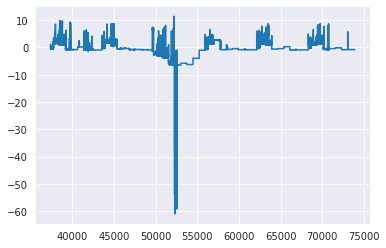

In [ ]:
plt.plot(final_preds.index,final_preds['Production'])

In [ ]:
final_preds.to_csv('Submission_LSTM.csv')

In [ ]:
from google.colab import files
files.download('Submission_LSTM.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

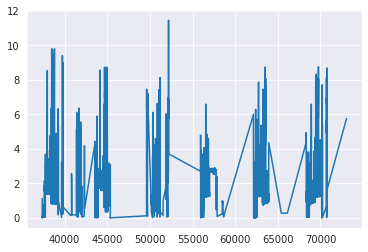

In [ ]:
plt.plot(final_preds[final_preds['Production'] > 0])